In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from rdkit import Chem
from rdkit.Chem import Draw

In [2]:
def convert(value):
    '''Convert scientific notation to numbers'''
    if 'e' in value:
        v1, v2 = value.split('e')
        num = float(v1) * 10 ** (int(v2))
        return str(num)
    else:
        return value
    
class webService():
    '''Calculate the similarity between query molecule and molecules in BindingDB database,
    retrieve the most similar molecule(s) and corresponding target by the cutoff, astertain
    the possible target by the available data.
    
    Examples
    --------
    Retrieve the similar molecules and target by the query smiles and cutoff:
    >>> web = webService('c1ccccc1', '0.8')
    >>> res = web.targetBySimilarity()
    >>> res.head(3)
    ...
    
    Sort the data by a particular column:
    >>> df_sorted = web.sortCol()
    ...
    
    draw the top n mols:
    >>> web.drawMols()

    '''
    def __init__(self):
        self.df_sorted = None
        
    def parseResults(self, props):
        soup = BeautifulSoup(self.r.content.decode('utf-8'), 'lxml')
        extrs = []
        if 'bdb:' in props[0]:
            cols = list(map(lambda x: x[4:], props))
            aff_col = 'bdb:affinities'
        else:
            cols = props
            aff_col = 'affinities'
        for link in soup.find_all(aff_col):
            extr = []
            for prop in props:
                prop_value = link.find(prop).string
                extr.append(prop_value)
            extrs.append(extr)
        # convert to df
        self.df = pd.DataFrame(extrs, columns=cols)
        self.df.rename(columns={'smile':'smiles'}, inplace=True)
    
    def getTargetBySimilarity(self, smiles, cutoff):
        '''Get the possible target by similarity
        
        smiles: the smiles of the query mol
        cutoff: the smilarity cutoff
        '''
        self.r = requests.get('http://bindingdb.org/axis2/services/BDBService/getTargetByCompound?smiles={}&cutoff={}'.format(smiles, cutoff))
        self.encode = self.r.encoding
        print(self.r.status_code, self.encode)
        props = ['bdb:monomerid', 'bdb:inhibitor', 'bdb:target', 'bdb:uniprot', 'bdb:species', 'bdb:affinity_type',
                'bdb:affinity', 'bdb:doi', 'bdb:smiles', 'bdb:inchi', 'bdb:tanimoto']
        self.parseResults(props)
        return self.df
        
    def getLigandsByUniprots(self, proteins, cutoff):
        '''Get the ligands by a set of protein IDs
        
        proteins: the ids of the query proteins split by ","
        cutoff: the affinity cutoff
        '''
        self.r = requests.get('http://bindingdb.org/axis2/services/BDBService/getLigandsByUniprots?uniprot={}&cutoff={}&code=[012]'.format(proteins, cutoff))
        self.encode = self.r.encoding
        print(self.r.status_code, self.encode)
        props = ['query', 'monomerid', 'smile', 'affinity_type', 'affinity', 'pmid', 'doi']
        self.parseResults(props)
        return self.df
        
    def getLigandsByUniprot(self, protein, cutoff):
        '''Get the ligands by a particular protein ID
        
        protein: the id of a protein
        cutoff: the affinity cutoff'''
        self.r = requests.get('http://bindingdb.org/axis2/services/BDBService/getLigandsByUniprot?uniprot={};{}'.format(protein, cutoff))
        self.encode = self.r.encoding
        print(self.r.status_code, self.encode)
        props = ['bdb:monomerid', 'bdb:smiles', 'bdb:affinity_type', 'bdb:affinity']
        self.parseResults(props)
        return self.df
        
    def sortCol(self, col='affinity'):
        '''Retrieve the records without "<|>" and sort the value'''
        df = self.df.copy(deep=True)
        df[col] = df[col].apply(convert)
        self.df_sorted = df[~df[col].str.contains('<|>')].sort_values(by=col)
        return self.df_sorted

    def drawMol(self, n=1, molsPerRow=4):
        '''Draw the top n mols'''
        if not isinstance(self.df_sorted, pd.DataFrame):
            self.sortCol()
        mols = self.df_sorted['smiles'].apply(Chem.MolFromSmiles).tolist()
        imgs = Draw.MolsToGridImage(mols, maxMols=n, molsPerRow=molsPerRow)
        return imgs

# 一、基于相似性推测化合物可能的靶点

初始化，设置查询分子

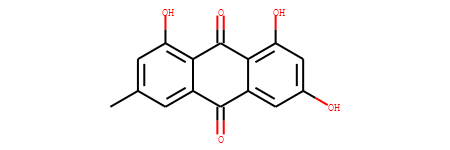

In [3]:
ws = webService()
smiles = 'CC1=CC(O)=C2C(=O)C3=C(O)C=C(O)C=C3C(=O)C2=C1'
sim_cutoff = 0.8
Chem.MolFromSmiles(smiles)

提取相似分子及相应靶点

In [4]:
df = ws.getTargetBySimilarity(smiles, sim_cutoff)
df.head(3)

200 UTF-8


,monomerid,inhibitor,target,uniprot,species,affinity_type,affinity,doi,smiles,inchi,tanimoto
0,50005912,BDBM50005912,Leukocyte elastase,P08246,Homo sapiens (Human),IC50,13000,10.1021/jm00087a014,Oc1cccc2C(=O)c3ccc(Cc4ccccc4)c(O)c3C(=O)c12,InChI=1S/C21H14O4/c22-16-8-4-7-14-17(16)21(25)...,0.89809
1,50206434,BDBM50206434,Amine oxidase [flavin-containing] B,P27338,Homo sapiens (Human),IC50,>60000,10.1016/j.bmcl.2017.01.085,Oc1ccc2C(=O)c3ccccc3C(=O)c2c1O,InChI=1S/C14H8O4/c15-10-6-5-9-11(14(10)18)13(1...,0.83226
2,67454,BDBM67454,Amine oxidase [flavin-containing] A,P21397,Homo sapiens (Human),Ki,422,10.1016/j.bmcl.2017.01.085,Oc1cc(O)c2C(=O)c3ccccc3C(=O)c2c1O,InChI=1S/C14H8O5/c15-8-5-9(16)14(19)11-10(8)12...,0.84076


自动对活性值排序

In [5]:
df_sorted = ws.sortCol()
df_sorted.head(3)

,monomerid,inhibitor,target,uniprot,species,affinity_type,affinity,doi,smiles,inchi,tanimoto
120,50041802,BDBM50041802,NAD-dependent protein deacetylase sirtuin-5 (S...,Q9NXA8,Homo sapiens (Human),IC50,100,None,Oc1cccc2Cc3cccc(O)c3C(=O)c12,InChI=1S/C14H10O3/c15-10-5-1-3-8-7-9-4-2-6-11(...,0.76974
6,50041419,BDBM50041419,Human immunodeficiency virus type 1 integrase,None,Human immunodeficiency virus 1,IC50,1000,10.1021/jm990322h,Oc1ccc2C(=O)c3c(O)ccc(O)c3C(=O)c2c1O,InChI=1S/C14H8O6/c15-6-3-4-7(16)11-10(6)12(18)...,0.82911
163,50041782,BDBM50041782,Arachidonate 5-lipoxygenase,None,Bos taurus,IC50,1000,10.1021/jm00037a017,Oc1ccc(O)c(Cc2cc(O)c3C(=O)c4c(O)cccc4Cc3c2)c1,InChI=1S/C21H16O5/c22-15-4-5-16(23)13(10-15)6-...,0.83544


# 二、获取某个蛋白的分子活性数据

设置搜索蛋白和活性阈值，并搜索

In [6]:
protein = 'P00185'
aff_cutoff = 1000
ws = webService()
df = ws.getLigandsByUniprot(protein, aff_cutoff)
df.head(3)

200 UTF-8


,monomerid,smiles,affinity_type,affinity
0,50027776,C#Cc1ccc(cc1)-c1ccccc1,Ki,270
1,50027778,C#Cc1ccc2ccc3cccc4ccc1c2c34,Ki,20
2,50027779,C#Cc1cc2cccc3ccc4cccc1c4c23,Ki,10


排序

In [7]:
df_sorted = ws.sortCol()
df_sorted.head(3)

,monomerid,smiles,affinity_type,affinity
2,50027779,C#Cc1cc2cccc3ccc4cccc1c4c23,Ki,10
7,50214612,CC#Cc1ccc2c(ccc3ccccc23)c1,Ki,10
11,50380104,COc1ccc(CC2=NN3C(=NN(C(C)=O)C3(C)c3ccc(C)cc3)N...,IC50,10.4


查看分子

D:\Anaconda3\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:188: UserWarning: Truncating the list of molecules to be displayed to 3. Change the maxMols value to display more.
  % (maxMols))


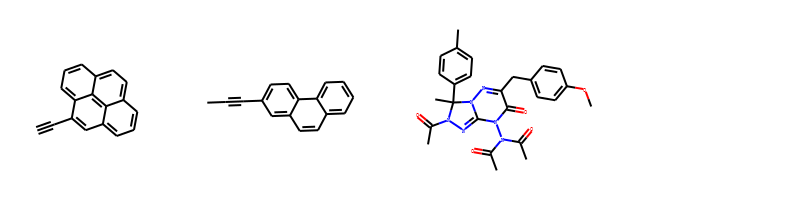

In [8]:
img = ws.drawMol(3)
img

# 三、获取一组蛋白的分子活性数据
同样设置、提取、查看活性最强的分子

200 UTF-8
(323, 7)


D:\Anaconda3\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:188: UserWarning: Truncating the list of molecules to be displayed to 1. Change the maxMols value to display more.
  % (maxMols))


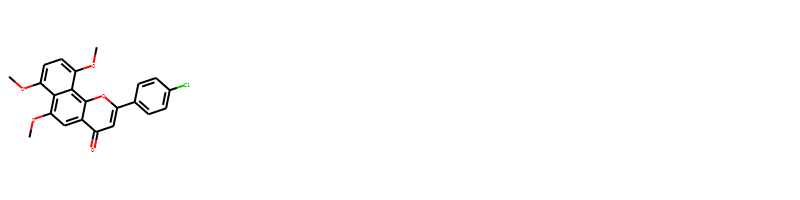

In [9]:
proteins = 'P04798,A4F3V9,A4F3W0,Q53G18,P00185'
aff_cutoff = 1000000000
ws = webService()
df = ws.getLigandsByUniprots(proteins, aff_cutoff)
print(df.shape)
img = ws.drawMol()
img